# Hypotension prediction using arterial blood pressure waveform

In this sample code, we will try to build a machine learning based model for predicting hypotension (MBP < 65mmHg for more than 1 minute) from the arterial blood pressure waveform (ART) in the VitalDB dataset.

## Required libraries

In [1]:
!pip install vitaldb
import vitaldb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # read track list
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # read case information

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 10.6 MB/s eta 0:00:00


In [ ]:
df_trks.shape

(486449, 3)

In [ ]:
df_trks.head() # tid = apis for per caseid which redirected to the main .vital file per class

caseid         tname                                       tid
0       1       BIS/BIS  fd869e25ba82a66cc95b38ed47110bf4f14bb368
1       1  BIS/EEG1_WAV  0aa685df768489a18a5e9f53af0d83bf60890c73
2       1  BIS/EEG2_WAV  ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3       1       BIS/EMG  2525603efe18d982764dbca457affe7a45e766a9
4       1       BIS/SEF  1c91aec859304840dec75acf4a35da78be0e8ef0

In [ ]:
df_trks.columns

Index(['caseid', 'tname', 'tid'], dtype='object')

In [ ]:
set(df_trks["tname"])

{'BIS/BIS',
 'BIS/EEG1_WAV',
 'BIS/EEG2_WAV',
 'BIS/EMG',
 'BIS/SEF',
 'BIS/SQI',
 'BIS/SR',
 'BIS/TOTPOW',
 'CardioQ/ABP',
 'CardioQ/CI',
 'CardioQ/CO',
 'CardioQ/FLOW',
 'CardioQ/FTc',
 'CardioQ/FTp',
 'CardioQ/HR',
 'CardioQ/MA',
 'CardioQ/MD',
 'CardioQ/PV',
 'CardioQ/SD',
 'CardioQ/SV',
 'CardioQ/SVI',
 'EV1000/ART_MBP',
 'EV1000/CI',
 'EV1000/CO',
 'EV1000/CVP',
 'EV1000/SV',
 'EV1000/SVI',
 'EV1000/SVR',
 'EV1000/SVRI',
 'EV1000/SVV',
 'FMS/FLOW_RATE',
 'FMS/INPUT_AMB_TEMP',
 'FMS/INPUT_TEMP',
 'FMS/OUTPUT_AMB_TEMP',
 'FMS/OUTPUT_TEMP',
 'FMS/PRESSURE',
 'FMS/TOTAL_VOL',
 'Invos/SCO2_L',
 'Invos/SCO2_R',
 'Orchestra/AMD_RATE',
 'Orchestra/AMD_VOL',
 'Orchestra/DEX2_RATE',
 'Orchestra/DEX2_VOL',
 'Orchestra/DEX4_RATE',
 'Orchestra/DEX4_VOL',
 'Orchestra/DOBU_RATE',
 'Orchestra/DOBU_VOL',
 'Orchestra/DOPA_RATE',
 'Orchestra/DOPA_VOL',
 'Orchestra/DTZ_RATE',
 'Orchestra/DTZ_VOL',
 'Orchestra/EPI_RATE',
 'Orchestra/EPI_VOL',
 'Orchestra/FUT_RATE',
 'Orchestra/FUT_VOL',
 'Orchestra/M

In [ ]:
len(set(df_trks["caseid"]))

6388

In [ ]:
df_cases.head()       #its kind of metadata

caseid  subjectid  casestart  caseend  anestart   aneend  opstart  opend  \
0       1       5955          0    11542      -552  10848.0     1668  10368   
1       2       2487          0    15741     -1039  14921.0     1721  14621   
2       3       2861          0     4394      -590   4210.0     1090   3010   
3       4       1903          0    20990      -778  20222.0     2522  17822   
4       5       4416          0    21531     -1009  22391.0     2591  20291   

      adm      dis  ...  intraop_colloid  intraop_ppf  intraop_mdz  \
0 -236220   627780  ...                0          120          0.0   
1 -221160  1506840  ...                0          150          0.0   
2 -218640    40560  ...                0            0          0.0   
3 -201120   576480  ...                0           80          0.0   
4  -67560  3734040  ...                0            0          0.0   

  intraop_ftn  intraop_rocu  intraop_vecu  intraop_eph  intraop_phe  \
0         100            70             0           10            0   
1           0           100             0           20            0   
2           0            50             0            0            0   
3         100           100             0           50            0   
4           0           160             0           10          900   

   intraop_epi intraop_ca  
0            0          0  
1            0          0  
2            0          0  
3            0          0  
4            0       2100  

[5 rows x 74 columns]

In [ ]:
len(set(df_cases["caseid"]))

6388

In [ ]:
df_cases.columns

Index(['caseid', 'subjectid', 'casestart', 'caseend', 'anestart', 'aneend',
       'opstart', 'opend', 'adm', 'dis', 'icu_days', 'death_inhosp', 'age',
       'sex', 'height', 'weight', 'bmi', 'asa', 'emop', 'department', 'optype',
       'dx', 'opname', 'approach', 'position', 'ane_type', 'preop_htn',
       'preop_dm', 'preop_ecg', 'preop_pft', 'preop_hb', 'preop_plt',
       'preop_pt', 'preop_aptt', 'preop_na', 'preop_k', 'preop_gluc',
       'preop_alb', 'preop_ast', 'preop_alt', 'preop_bun', 'preop_cr',
       'preop_ph', 'preop_hco3', 'preop_be', 'preop_pao2', 'preop_paco2',
       'preop_sao2', 'cormack', 'airway', 'tubesize', 'dltubesize', 'lmasize',
       'iv1', 'iv2', 'aline1', 'aline2', 'cline1', 'cline2', 'intraop_ebl',
       'intraop_uo', 'intraop_rbc', 'intraop_ffp', 'intraop_crystalloid',
       'intraop_colloid', 'intraop_ppf', 'intraop_mdz', 'intraop_ftn',
       'intraop_rocu', 'intraop_vecu', 'intraop_eph', 'intraop_phe',
       'intraop_epi', 'intraop_ca'],
     

## Case Filtering

In [3]:
# inclusion & exclusion criteria
caseids = list(
    set(df_trks[df_trks['tname'] == 'SNUADC/ART']['caseid']) & #selecting which caseid has "SNUADC/ART"
    
    set(df_cases[df_cases['age'] > 18]['caseid']) &            #selecting adult patient
    set(df_cases[df_cases['age'] >= 18]['caseid']) &           #selecting adult patient
    set(df_cases[df_cases['weight'] >= 30]['caseid']) &        #weight filtering
    set(df_cases[df_cases['weight'] < 140]['caseid']) &        #weight filtering
    set(df_cases[df_cases['height'] >= 135]['caseid']) &       #height filtering
    set(df_cases[df_cases['height'] < 200]['caseid']) &        #height filtering
    set(df_cases[~df_cases['opname'].str.contains("transplant", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aneurysm", case=False)]['caseid']) & 
    set(df_cases[~df_cases['opname'].str.contains("aorto", case=False)]['caseid'])& 
    set(df_cases[df_cases['ane_type'] == 'General']['caseid'])
)
print('Total {} cases found'.format(len(caseids)))
np.random.shuffle(caseids)  # shuffle caseids

Total 3312 cases found


## Preprocessing

In this section, we will read the MBP data while iterating caseids. Only MAX_CASES (=100) cases will be used for to save time.

The arterial waveform data of each case will be read by passing the caseid into the vitaldb python library. Then, the pairs of x (input) and y (label) for training and validation of the model will be extracted.

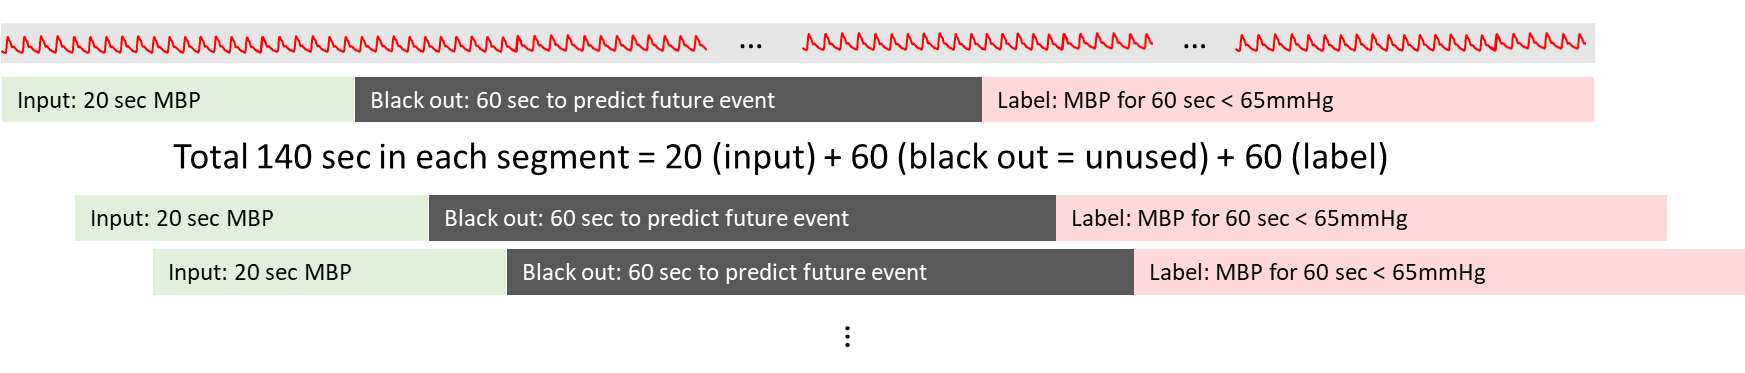

In [ ]:
MINUTES_AHEAD = 1    #Predict hypotension 1 minutes ahead
FEAT_TIME = 20       #MBP time
BLACKOUT_TIME = 60   #Blackout time
BATCH_SIZE = 256     #Batch size for learning
MAX_CASES = 100      #Maximum number of cases for this example
SRATE = 100          #sampling rate for the arterial waveform signal

In [ ]:
arts = vitaldb.load_case(1, ['SNUADC/ART'], 1 / SRATE).flatten()


In [ ]:
len(arts)

1154111

In [ ]:

single_sample_time = (FEAT_TIME+ BLACKOUT_TIME + MINUTES_AHEAD * 60)
print(single_sample_time)

140


In [ ]:
SRATE * single_sample_time

14000

In [ ]:
len(arts) - SRATE * single_sample_time, 10 * SRATE

(1140111, 1000)

In [ ]:
SRATE * (FEAT_TIME + MINUTES_AHEAD * 60)

8000

In [ ]:
SRATE * (20 + (MINUTES_AHEAD + BLACKOUT_TIME) * 60)

368000

In [ ]:
for i in range(0, len(arts) - SRATE * single_sample_time, 10 * SRATE):

egx = arts[i:i + SRATE * FEAT_TIME]
segy = arts[i + SRATE * (FEAT_TIME + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + BLACKOUT_TIME) * 60)]

In [4]:
from tqdm.notebook import tqdm
MINUTES_AHEAD = 1  # Predict hypotension 1 minutes ahead
BATCH_SIZE = 256  # Batch size for learning
MAX_CASES = 100  # Maximum number of cases for this example
SRATE = 100  # sampling rate for the arterial waveform signal

# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in tqdm(caseids):
    print(f'loading {caseid}', end='...', flush=True)

    # read the arterial waveform
    arts = vitaldb.load_case(caseid, ['SNUADC/ART'], 1 / SRATE).flatten()

    case_sample = 0
    case_event = 0
    for i in tqdm(range(0, len(arts) - SRATE * (20 + (1 + MINUTES_AHEAD) * 60), 10 * SRATE)):
        segx = arts[i:i + SRATE * 20]
        segy = arts[i + SRATE * (20 + MINUTES_AHEAD * 60):i + SRATE * (20 + (MINUTES_AHEAD + 1) * 60)]

        # check the validity of this segment
        valid = True
        if np.isnan(segx).mean() > 0.1:
            valid = False
        elif np.isnan(segy).mean() > 0.1:
            valid = False
        elif (segx > 200).any():
            valid = False
        elif (segy > 200).any():
            valid = False
        elif (segx < 30).any():
            valid = False
        elif (segy < 30).any():
            valid = False
        elif np.max(segx) - np.min(segx) < 30:
            valid = False
        elif np.max(segy) - np.min(segy) < 30:
            valid = False
        elif (np.abs(np.diff(segx)) > 30).any():  # abrupt change -> noise
            valid = False
        elif (np.abs(np.diff(segy)) > 30).any():  # abrupt change -> noise
            valid = False

        # 2 sec moving avg
        n = 2 * SRATE  
        segy = np.nancumsum(segy, dtype=np.float32)
        segy[n:] = segy[n:] - segy[:-n]
        segy = segy[n - 1:] / n

        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        valid_mask.append(valid)
        c.append(caseid)
        
        if valid:
            case_sample += 1
            if evt:
                case_event += 1

    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100 * case_event / case_sample))
    else:
        print('no sample')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

# convert lists to numpy array
x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

# normalization
x -= 65
x /= 65

# add axis for CNN
x = x[...,None]  

print(x.shape)
print(y.shape)

  0%|          | 0/3312 [00:00<?, ?it/s]

loading 4520...

  0%|          | 0/1628 [00:00<?, ?it/s]

1254 samples 18 (1.4 %) events
loading 817...

  0%|          | 0/1194 [00:00<?, ?it/s]

no sample
loading 3404...

  0%|          | 0/1123 [00:00<?, ?it/s]

755 samples 0 (0.0 %) events
loading 4711...

  0%|          | 0/1310 [00:00<?, ?it/s]

1124 samples 50 (4.4 %) events
loading 4240...

  0%|          | 0/1896 [00:00<?, ?it/s]

1080 samples 94 (8.7 %) events
loading 3044...

  0%|          | 0/2083 [00:00<?, ?it/s]

1410 samples 7 (0.5 %) events
loading 4411...

  0%|          | 0/1211 [00:00<?, ?it/s]

914 samples 0 (0.0 %) events
loading 190...

  0%|          | 0/1580 [00:00<?, ?it/s]

1159 samples 0 (0.0 %) events
loading 1914...

  0%|          | 0/1022 [00:00<?, ?it/s]

829 samples 21 (2.5 %) events
loading 2225...

  0%|          | 0/2192 [00:00<?, ?it/s]

1778 samples 20 (1.1 %) events
loading 1311...

  0%|          | 0/748 [00:00<?, ?it/s]

510 samples 0 (0.0 %) events
loading 4750...

  0%|          | 0/1790 [00:00<?, ?it/s]

1546 samples 0 (0.0 %) events
loading 4538...

  0%|          | 0/933 [00:00<?, ?it/s]

618 samples 29 (4.7 %) events
loading 3075...

  0%|          | 0/1590 [00:00<?, ?it/s]

1302 samples 0 (0.0 %) events
loading 1907...

  0%|          | 0/881 [00:00<?, ?it/s]

617 samples 5 (0.8 %) events
loading 1699...

  0%|          | 0/1184 [00:00<?, ?it/s]

794 samples 0 (0.0 %) events
loading 3142...

  0%|          | 0/1093 [00:00<?, ?it/s]

43 samples 7 (16.3 %) events
loading 2888...

  0%|          | 0/1123 [00:00<?, ?it/s]

896 samples 0 (0.0 %) events
loading 2283...

  0%|          | 0/945 [00:00<?, ?it/s]

635 samples 0 (0.0 %) events
loading 377...

  0%|          | 0/568 [00:00<?, ?it/s]

no sample
loading 5743...

  0%|          | 0/1168 [00:00<?, ?it/s]

897 samples 7 (0.8 %) events
loading 1486...

  0%|          | 0/2912 [00:00<?, ?it/s]

2309 samples 7 (0.3 %) events
loading 2630...

  0%|          | 0/1097 [00:00<?, ?it/s]

759 samples 51 (6.7 %) events
loading 3394...

  0%|          | 0/2318 [00:00<?, ?it/s]

1951 samples 24 (1.2 %) events
loading 853...

  0%|          | 0/1143 [00:00<?, ?it/s]

891 samples 16 (1.8 %) events
loading 5364...

  0%|          | 0/1516 [00:00<?, ?it/s]

1160 samples 76 (6.6 %) events
loading 4122...

  0%|          | 0/1094 [00:00<?, ?it/s]

765 samples 0 (0.0 %) events
loading 6359...

  0%|          | 0/775 [00:00<?, ?it/s]

515 samples 143 (27.8 %) events
loading 6116...

  0%|          | 0/1426 [00:00<?, ?it/s]

1121 samples 30 (2.7 %) events
loading 3682...

  0%|          | 0/692 [00:00<?, ?it/s]

551 samples 12 (2.2 %) events
loading 3340...

  0%|          | 0/842 [00:00<?, ?it/s]

598 samples 0 (0.0 %) events
loading 3403...

  0%|          | 0/1294 [00:00<?, ?it/s]

950 samples 27 (2.8 %) events
loading 680...

  0%|          | 0/645 [00:00<?, ?it/s]

388 samples 59 (15.2 %) events
loading 1817...

  0%|          | 0/1004 [00:00<?, ?it/s]

no sample
loading 398...

  0%|          | 0/1115 [00:00<?, ?it/s]

762 samples 0 (0.0 %) events
loading 4830...

  0%|          | 0/523 [00:00<?, ?it/s]

255 samples 0 (0.0 %) events
loading 2462...

  0%|          | 0/1611 [00:00<?, ?it/s]

1286 samples 8 (0.6 %) events
loading 4074...

  0%|          | 0/1495 [00:00<?, ?it/s]

1246 samples 0 (0.0 %) events
loading 4251...

  0%|          | 0/2282 [00:00<?, ?it/s]

1849 samples 290 (15.7 %) events
loading 117...

  0%|          | 0/1130 [00:00<?, ?it/s]

943 samples 49 (5.2 %) events
loading 1008...

  0%|          | 0/1258 [00:00<?, ?it/s]

848 samples 0 (0.0 %) events
loading 5366...

  0%|          | 0/648 [00:00<?, ?it/s]

441 samples 0 (0.0 %) events
loading 4925...

  0%|          | 0/888 [00:00<?, ?it/s]

675 samples 0 (0.0 %) events
loading 1950...

  0%|          | 0/1219 [00:00<?, ?it/s]

935 samples 0 (0.0 %) events
loading 4736...

  0%|          | 0/529 [00:00<?, ?it/s]

no sample
loading 1961...

  0%|          | 0/2118 [00:00<?, ?it/s]

2004 samples 28 (1.4 %) events
loading 3431...

  0%|          | 0/1387 [00:00<?, ?it/s]

1037 samples 0 (0.0 %) events
loading 1052...

  0%|          | 0/1321 [00:00<?, ?it/s]

1116 samples 0 (0.0 %) events
loading 2309...

  0%|          | 0/825 [00:00<?, ?it/s]

441 samples 6 (1.4 %) events
loading 2375...

  0%|          | 0/2159 [00:00<?, ?it/s]

1876 samples 35 (1.9 %) events
loading 268...

  0%|          | 0/573 [00:00<?, ?it/s]

436 samples 0 (0.0 %) events
loading 5777...

  0%|          | 0/1766 [00:00<?, ?it/s]

1457 samples 0 (0.0 %) events
loading 5490...

  0%|          | 0/1442 [00:00<?, ?it/s]

1022 samples 53 (5.2 %) events
loading 892...

  0%|          | 0/739 [00:00<?, ?it/s]

524 samples 2 (0.4 %) events
loading 1684...

  0%|          | 0/603 [00:00<?, ?it/s]

440 samples 38 (8.6 %) events
loading 1554...

  0%|          | 0/586 [00:00<?, ?it/s]

357 samples 0 (0.0 %) events
loading 1065...

  0%|          | 0/1162 [00:00<?, ?it/s]

520 samples 0 (0.0 %) events
loading 1623...

  0%|          | 0/1507 [00:00<?, ?it/s]

340 samples 7 (2.1 %) events
loading 1567...

  0%|          | 0/946 [00:00<?, ?it/s]

486 samples 53 (10.9 %) events
loading 2774...

  0%|          | 0/433 [00:00<?, ?it/s]

238 samples 3 (1.3 %) events
loading 1155...

  0%|          | 0/1309 [00:00<?, ?it/s]

no sample
loading 297...

  0%|          | 0/1121 [00:00<?, ?it/s]

897 samples 0 (0.0 %) events
loading 1597...

  0%|          | 0/1816 [00:00<?, ?it/s]

1501 samples 0 (0.0 %) events
loading 4749...

  0%|          | 0/2568 [00:00<?, ?it/s]

1860 samples 119 (6.4 %) events
loading 2354...

  0%|          | 0/1631 [00:00<?, ?it/s]

1367 samples 11 (0.8 %) events
loading 2298...

  0%|          | 0/632 [00:00<?, ?it/s]

490 samples 9 (1.8 %) events
loading 4073...

  0%|          | 0/998 [00:00<?, ?it/s]

674 samples 0 (0.0 %) events
loading 3077...

  0%|          | 0/1279 [00:00<?, ?it/s]

1062 samples 105 (9.9 %) events
loading 4894...

  0%|          | 0/1593 [00:00<?, ?it/s]

1248 samples 15 (1.2 %) events
loading 3235...

  0%|          | 0/688 [00:00<?, ?it/s]

456 samples 84 (18.4 %) events
loading 4632...

  0%|          | 0/1820 [00:00<?, ?it/s]

1397 samples 1 (0.1 %) events
loading 4109...

  0%|          | 0/505 [00:00<?, ?it/s]

254 samples 22 (8.7 %) events
loading 13...

  0%|          | 0/1068 [00:00<?, ?it/s]

638 samples 41 (6.4 %) events
loading 4332...

  0%|          | 0/561 [00:00<?, ?it/s]

370 samples 1 (0.3 %) events
loading 3128...

  0%|          | 0/743 [00:00<?, ?it/s]

449 samples 0 (0.0 %) events
loading 4860...

  0%|          | 0/511 [00:00<?, ?it/s]

278 samples 4 (1.4 %) events
loading 3205...

  0%|          | 0/720 [00:00<?, ?it/s]

489 samples 212 (43.4 %) events
loading 1615...

  0%|          | 0/2014 [00:00<?, ?it/s]

1639 samples 0 (0.0 %) events
loading 4362...

  0%|          | 0/1102 [00:00<?, ?it/s]

835 samples 63 (7.5 %) events
loading 6131...

  0%|          | 0/633 [00:00<?, ?it/s]

396 samples 152 (38.4 %) events
loading 2421...

  0%|          | 0/1456 [00:00<?, ?it/s]

1235 samples 0 (0.0 %) events
loading 1246...

  0%|          | 0/1188 [00:00<?, ?it/s]

967 samples 2 (0.2 %) events
loading 2703...

  0%|          | 0/2336 [00:00<?, ?it/s]

1953 samples 1 (0.1 %) events
loading 3012...

  0%|          | 0/368 [00:00<?, ?it/s]

no sample
loading 6018...

  0%|          | 0/1093 [00:00<?, ?it/s]

875 samples 0 (0.0 %) events
loading 5495...

  0%|          | 0/1402 [00:00<?, ?it/s]

1202 samples 0 (0.0 %) events
loading 5942...

  0%|          | 0/947 [00:00<?, ?it/s]

619 samples 8 (1.3 %) events
loading 415...

  0%|          | 0/825 [00:00<?, ?it/s]

549 samples 46 (8.4 %) events
loading 5870...

  0%|          | 0/2101 [00:00<?, ?it/s]

1645 samples 0 (0.0 %) events
loading 4733...

  0%|          | 0/419 [00:00<?, ?it/s]

4 samples 0 (0.0 %) events
loading 2000...

  0%|          | 0/1569 [00:00<?, ?it/s]

1260 samples 0 (0.0 %) events
loading 6307...

  0%|          | 0/1210 [00:00<?, ?it/s]

860 samples 0 (0.0 %) events
loading 4569...

  0%|          | 0/422 [00:00<?, ?it/s]

270 samples 22 (8.1 %) events
loading 699...

  0%|          | 0/2315 [00:00<?, ?it/s]

1231 samples 223 (18.1 %) events
loading 2501...

  0%|          | 0/1957 [00:00<?, ?it/s]

1695 samples 0 (0.0 %) events
loading 1986...

  0%|          | 0/743 [00:00<?, ?it/s]

531 samples 0 (0.0 %) events
loading 1689...

  0%|          | 0/820 [00:00<?, ?it/s]

642 samples 0 (0.0 %) events
loading 281...

  0%|          | 0/1121 [00:00<?, ?it/s]

858 samples 3 (0.3 %) events
loading 624...

  0%|          | 0/1177 [00:00<?, ?it/s]

729 samples 41 (5.6 %) events
loading 1687...

  0%|          | 0/1106 [00:00<?, ?it/s]

788 samples 0 (0.0 %) events
(122172, 2000, 1)
(122172,)


## Splitting samples into training and testing dataset


In [5]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# splitting into train set and test set
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

train_x = x[train_mask]
train_y = y[train_mask]
test_x = x[test_mask]
test_y = y[test_mask]

train_x_valid = x[train_mask & valid_mask]
train_y_valid = y[train_mask & valid_mask]
test_x_valid = x[test_mask & valid_mask]
test_y_valid = y[test_mask & valid_mask]

testname = '{} cases {} ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), \
    len(train_y_valid), sum(train_y_valid), 100 * np.mean(train_y_valid), \
    len(test_y_valid), sum(test_y_valid), 100 * np.mean(test_y_valid))
print(testname)

100 cases 1 ahead batchsize=256 total 122172, train 67794 (1853 events 2.7%), test 18072 (607 events 3.4%)


## Model building and training

In [ ]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# hyper parameter
CNN_LAYERS = [64] * 6

# build a model
model = Sequential()
for num_node in CNN_LAYERS:
    model.add(Conv1D(filters=num_node, kernel_size=3, padding='valid'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])

hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
275/275 [==============================] - ETA: 0s - loss: 0.2382 - accuracy: 0.9349 - auc: 0.9530
Epoch 1: val_loss improved from inf to 0.01857, saving model to output/weights.hdf5
275/275 [==============================] - 41s 88ms/step - loss: 0.2382 - accuracy: 0.9349 - auc: 0.9530 - val_loss: 0.0186 - val_accuracy: 0.9979 - val_auc: 0.9480
Epoch 2/100
274/275 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9442 - auc: 0.9626
Epoch 2: val_loss did not improve from 0.01857
275/275 [==============================] - 23s 83ms/step - loss: 0.2115 - accuracy: 0.9442 - auc: 0.9626 - val_loss: 0.0237 - val_accuracy: 0.9923 - val_auc: 0.9451
Epoch 3/100
274/275 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9456 - auc: 0.9645
Epoch 3: val_loss did not improve from 0.01857
275/275 [==============================] - 23s 84ms/step - loss: 0.2063 - accuracy: 0.9456 - auc: 0.9645 - val_loss: 0.0236 - val_accuracy: 0.9918 - val_auc: 0

9291

## Evaluation of the model performance

In [ ]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

# make prediction on the test dataset
test_p = model.predict(test_x, BATCH_SIZE).flatten()
test_p_valid = test_p[valid_mask[test_mask]]

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_p_valid)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_p_valid)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_p_valid > thval)
acc = accuracy_score(test_y_valid, test_p_valid > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_p_valid > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)

# rename final output folder
odir = testname + ' ' + testres
os.rename(tempdir, odir)

# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('{}/auroc.png'.format(odir))
plt.close()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('{}/auprc.png'.format(odir))
plt.close()

86/86 [==============================] - 2s 23ms/step
auroc=0.977, auprc=0.694 acc=0.937, F1=0.094, PPV=75.7, NPV=93.7, TN=15057, fp=17, fn=1007, TP=53


## Plotting each case in the test dataset

5117	0.5705754444711099	


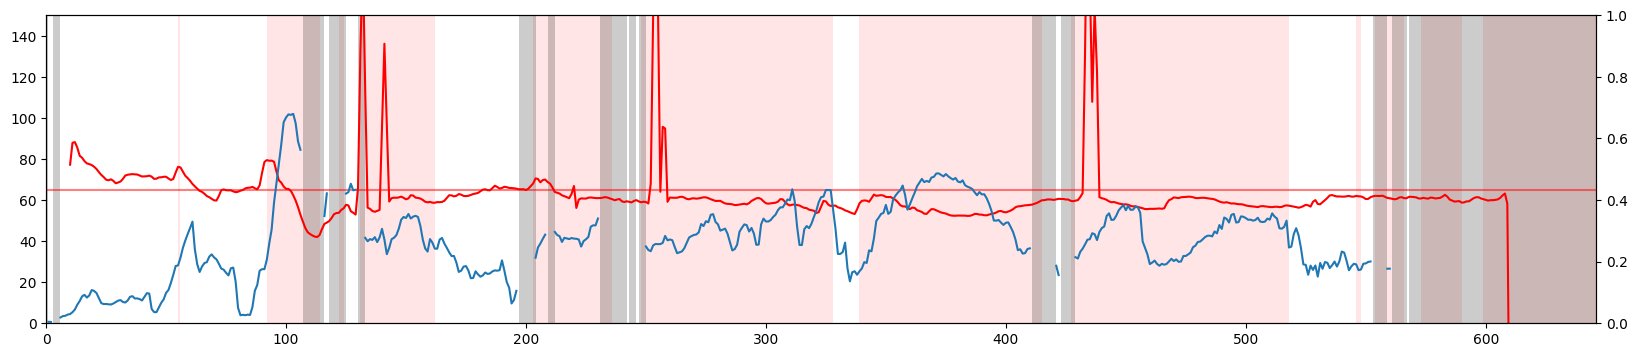

5122	0.021263253957878276	


<ipython-input-43-9367ec9924db>:34: RuntimeWarning: Mean of empty slice
  ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')


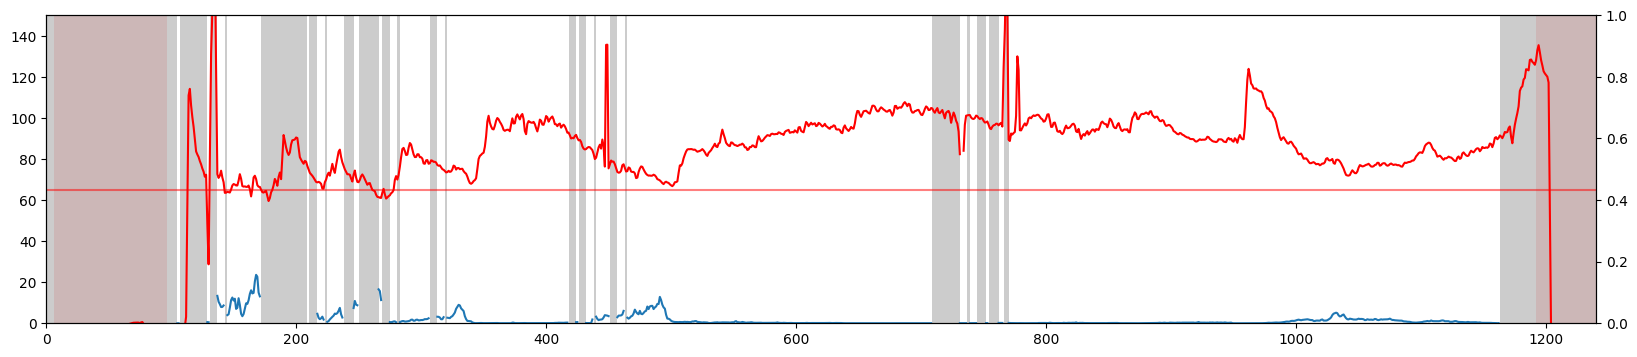

5265	0.0028541340542818424	


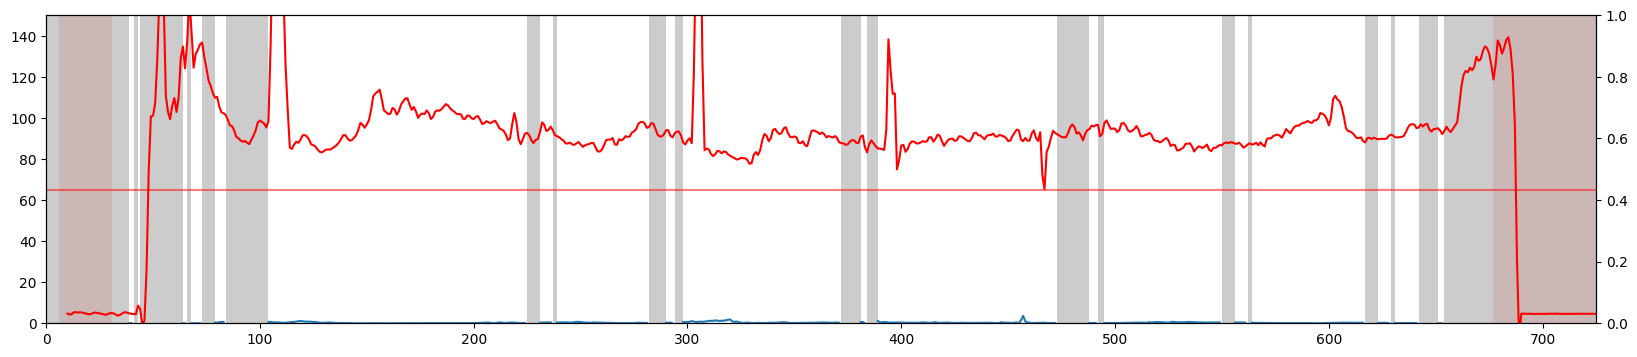

5288	0.21724207590344266	


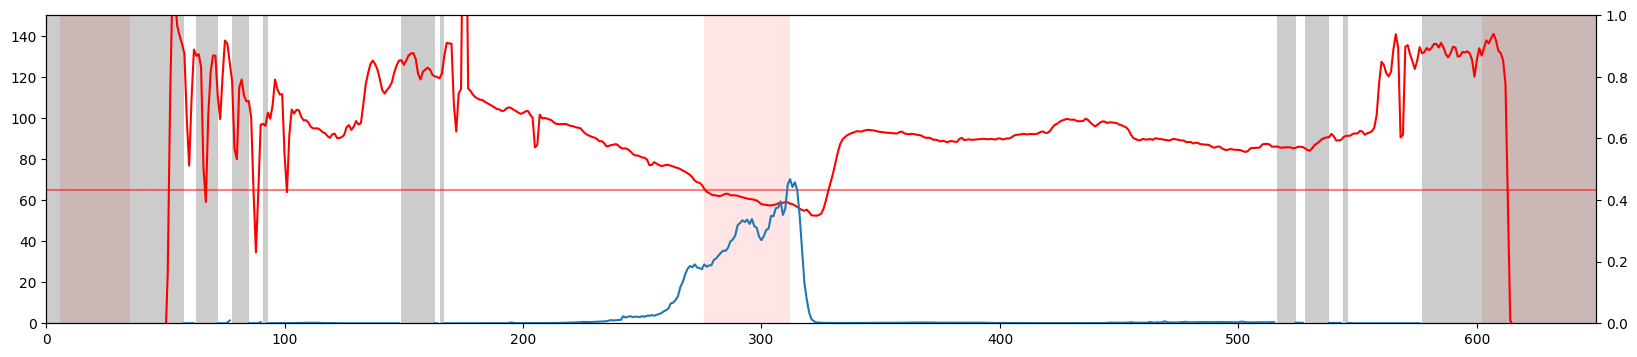

5309	0.013641364889121519	


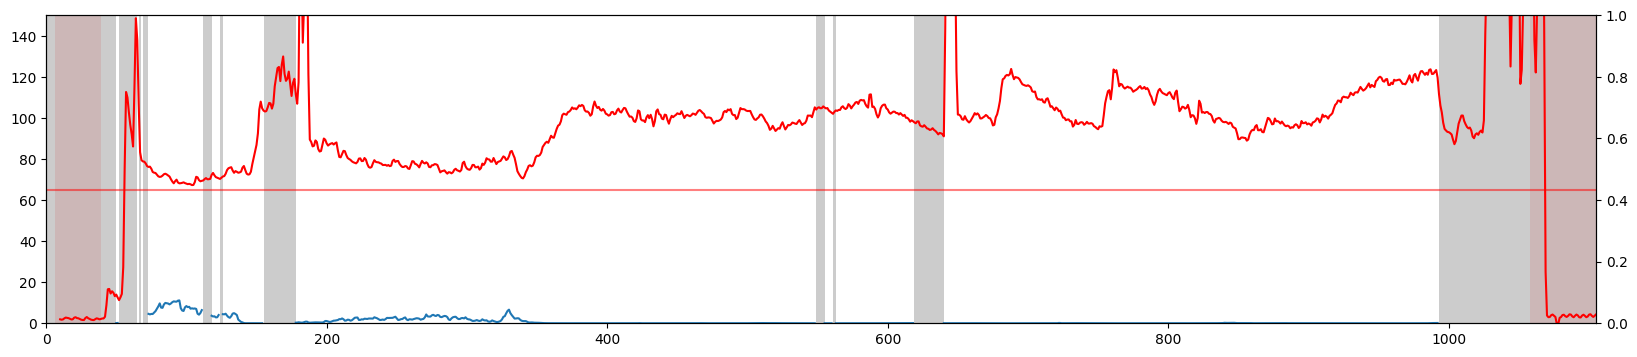

5328	0.37557623221345016	


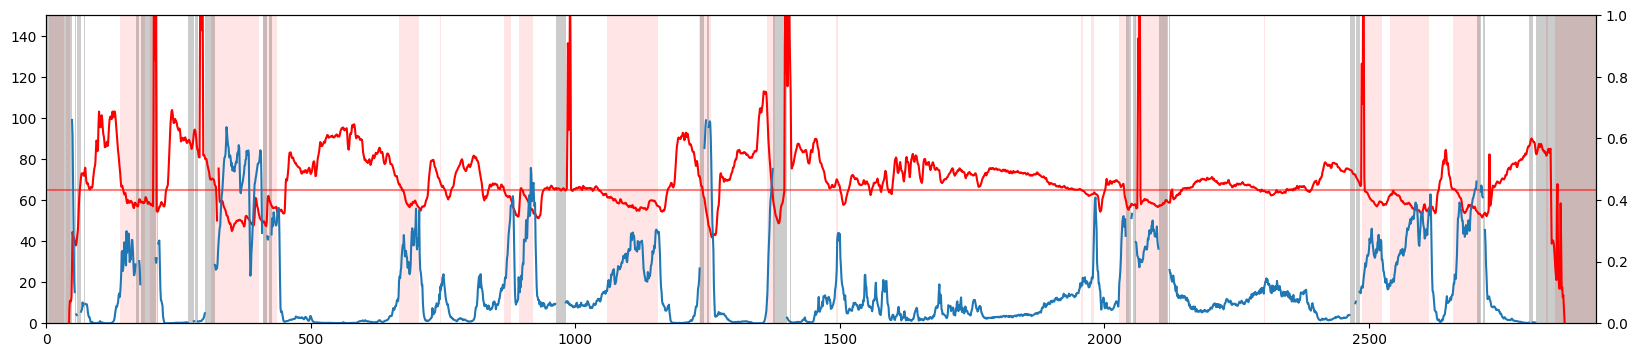

5368	0.050436299438705944	


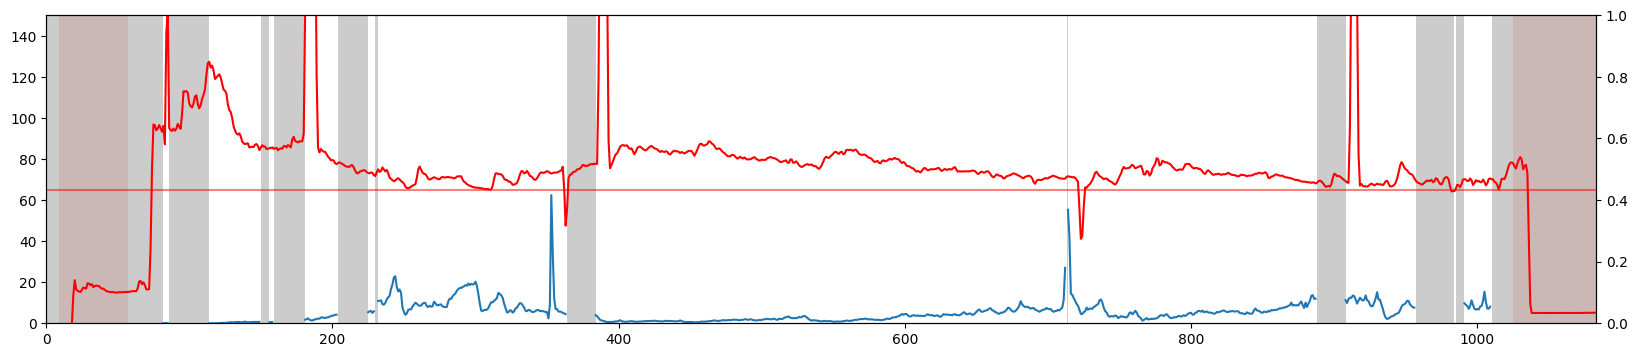

5394	0.03058867374691842	


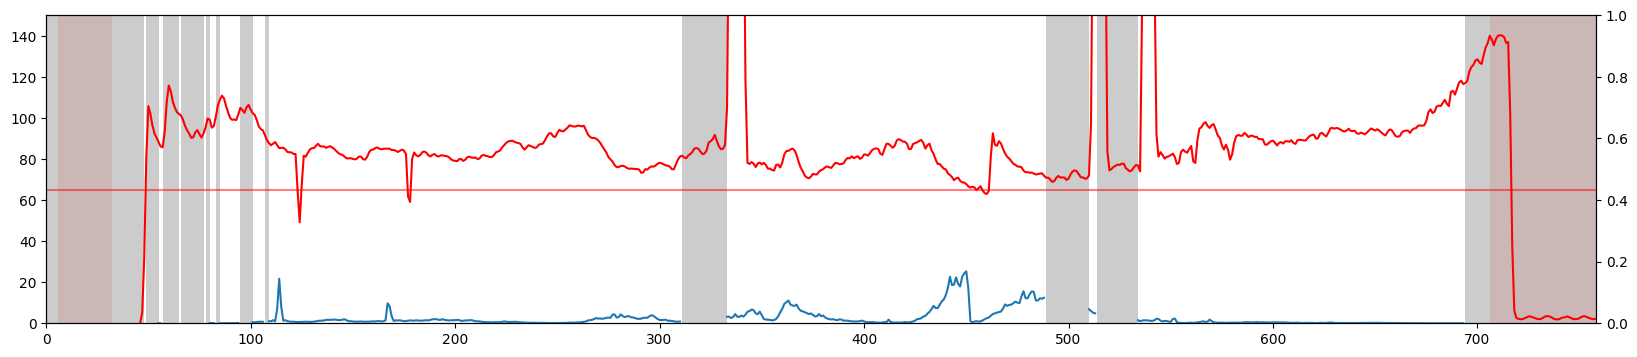

5627	0.030254591759524455	


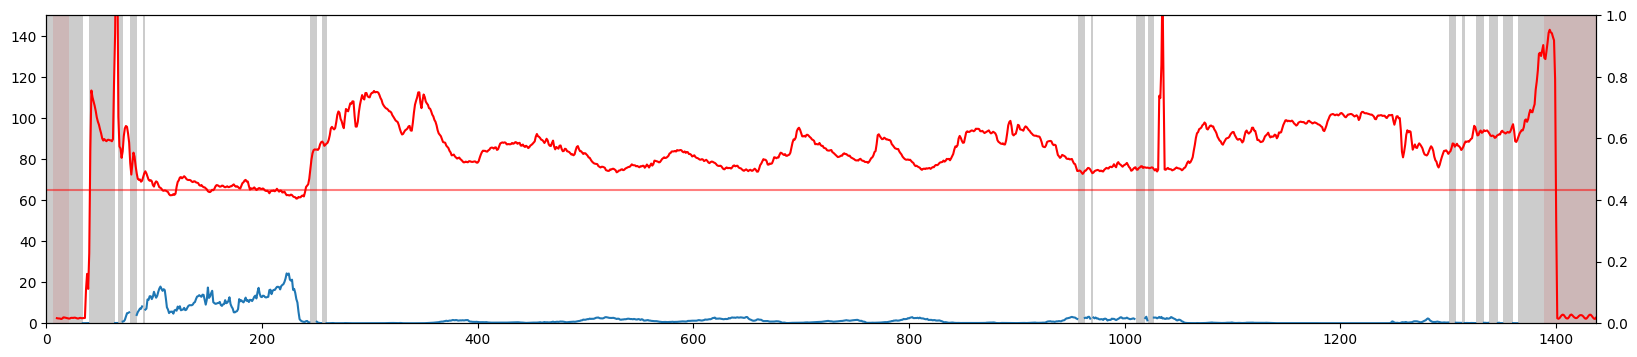

5629	0.05130517719512005	


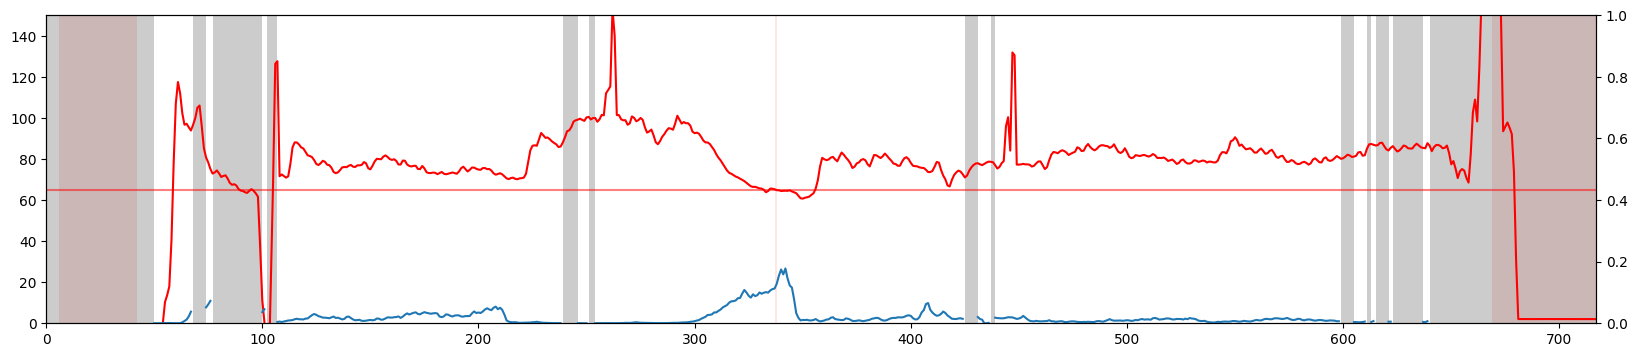

5662	0.0008430241591089037	


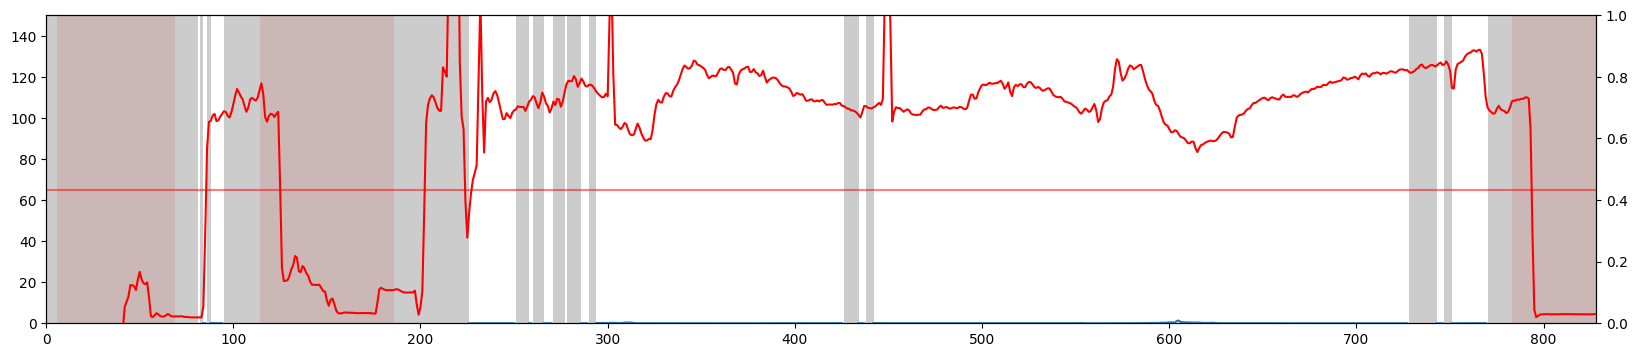

5719	0.040384901160447996	


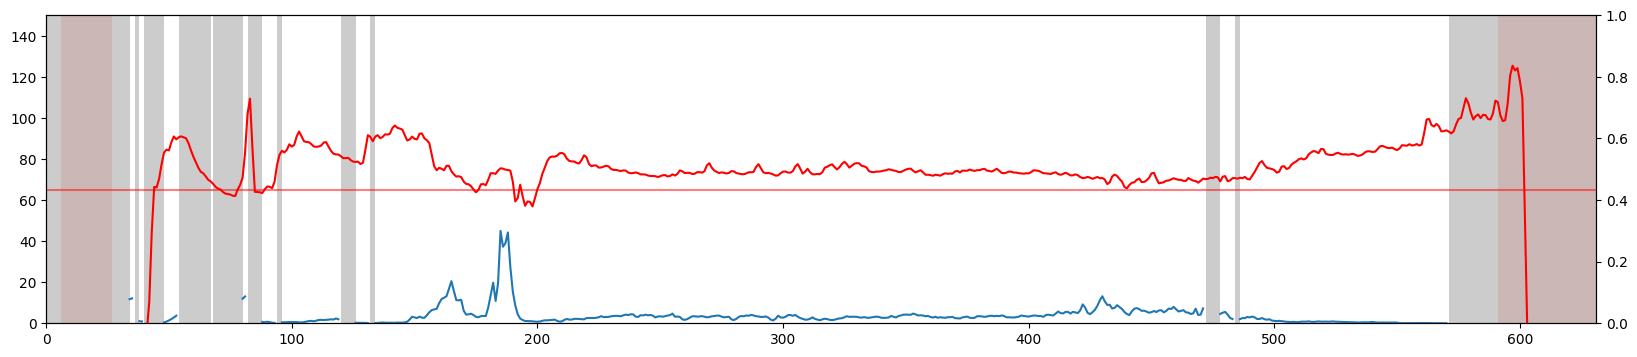

5827	0.022890896954239168	


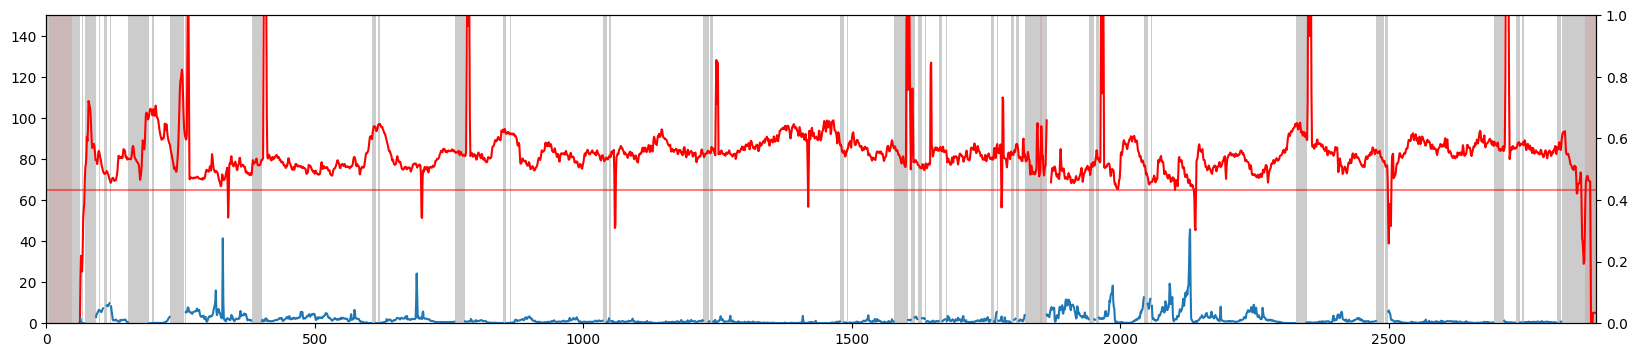

5895	0.14154311322099175	


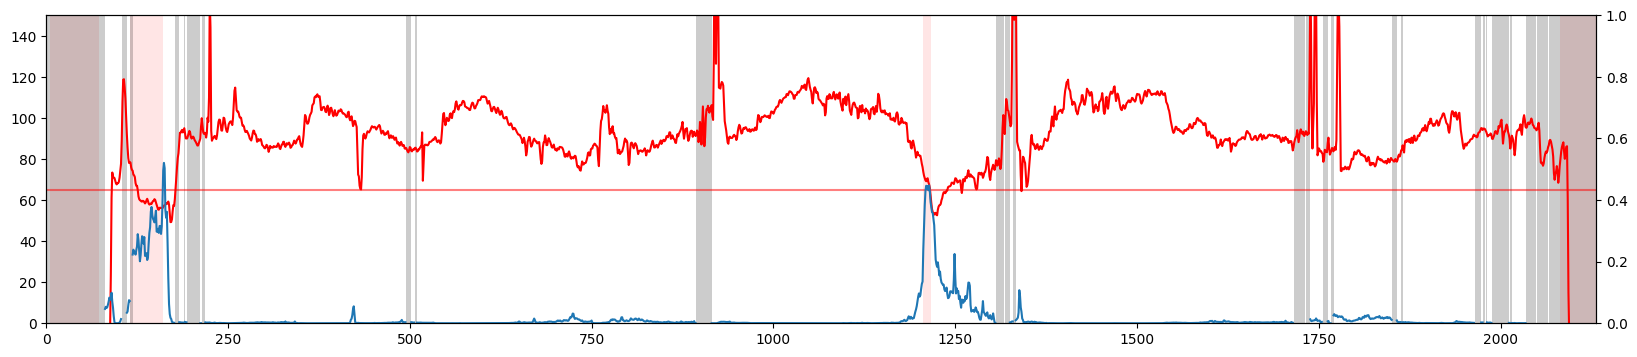

5971	0.0006473047737676147	


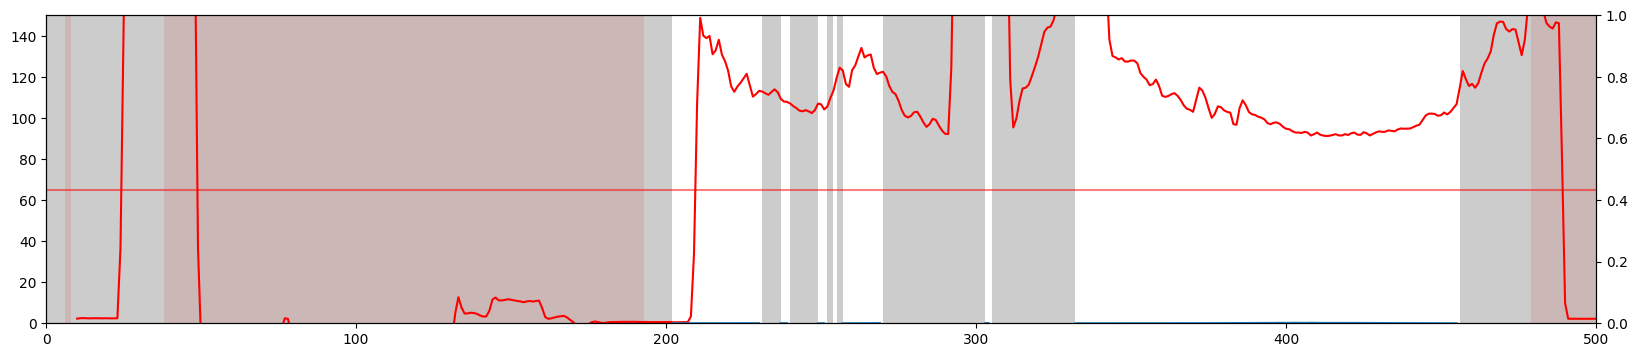

6076	0.19679367149141386	


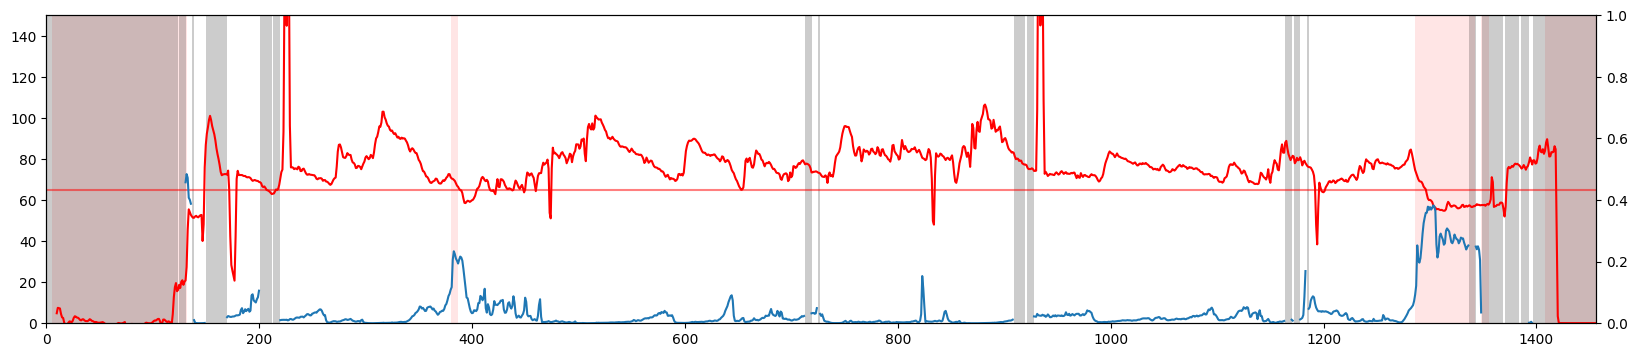

6093	0.0927039237348853	


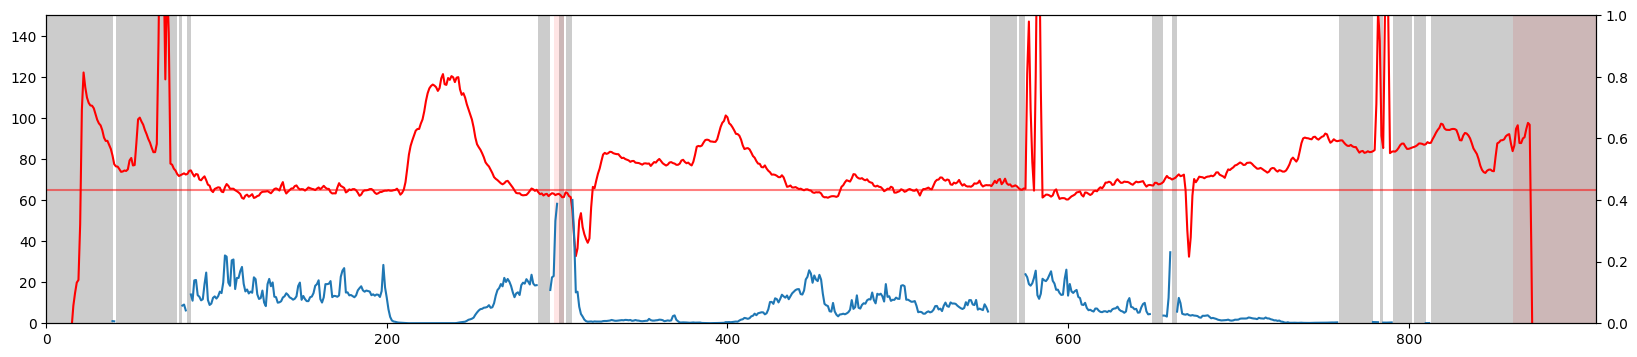

6204	0.07032884964000709	


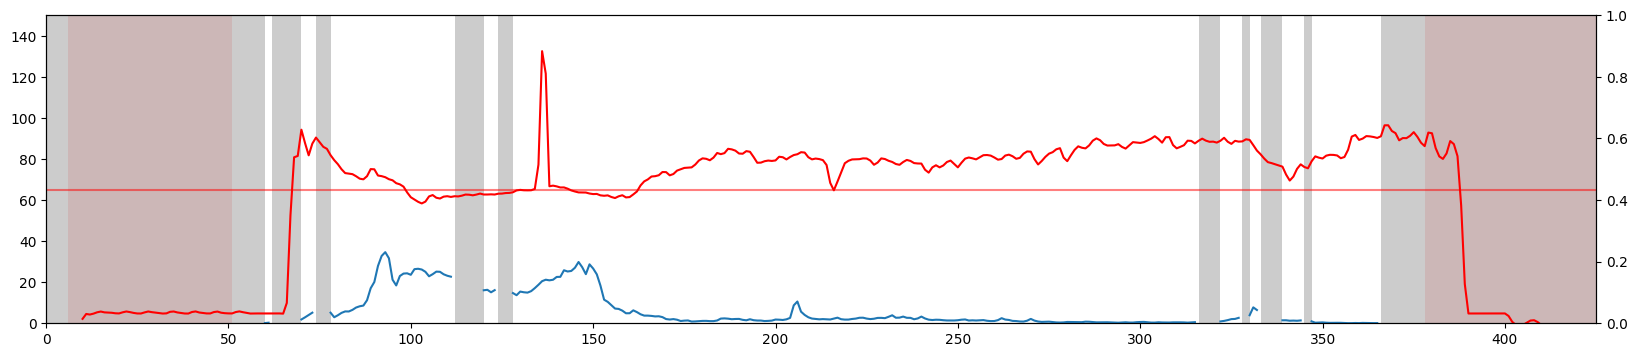

In [ ]:
for caseid in caseids_test:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = test_x[case_mask]
    case_y = test_y[case_mask]
    case_p = test_p[case_mask]
    case_valid_mask = valid_mask[test_mask][case_mask]
    case_p[~case_valid_mask] = np.nan
    if sum(case_valid_mask) == 0:
        continue
    
    # calculate error for this case
    case_rmse = np.nanmean(np.square(case_y - case_p)) ** 0.5
    print('{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 6, i + MINUTES_AHEAD * 6 + 1, color='r', alpha=0.1, lw=0)
        if not case_valid_mask[i]:
            ax1.axvspan(i, i + 1, color='k', alpha=0.2, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, np.nanmean(test_x[case_mask], axis=1) * 65 + 65, color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples only
    ax2.plot(t, case_p)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()